#### Resources:
- Paul Centore - A Zonohedral Approach to Optimal Colours
(https://legacy.sites.fas.harvard.edu/~cs278/papers/zone.pdf)
- Jessica Lee - Theory of Human Tetrachromatic Color Experience and Printing (https://imjal.github.io/theory-of-tetrachromacy/static/pdfs/Lee_TheoryofTet_v1.pdf)

#### Instructions:
Make sure to install Jessica's repository as a Python package using the line below. It requires Python 3.11.

In [77]:
!pip install -q git+https://github.com/VarunNSrivastava/ChromaLab

6699.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [78]:
from chromalab.observer import Observer
from chromalab.spectra import Spectra, Illuminant
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
import matplotlib.animation as animation
import pandas as pd
%matplotlib widget

# 4D Color Solid (RGBA) Visualization
Structure: vertices is initialized as a 4D array. The first three dimensions represent the RGB coordinates (cone responses), while the fourth dimension is reserved for the alpha value (transparency).
Alpha Computation:The alpha value is derived by normalizing the wavelength for each vertex, scaling the range [395,731] (visible spectrum) to [0,1].
Effect: Shorter wavelengths (e.g., violet) have lower alpha values, while longer wavelengths (e.g., red) have higher alpha values.
Usage: The 4D vertices encapsulate both the RGB color values and their corresponding transparency levels.

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm

class ObjectColorSolidAlpha2:
    def __init__(self, observer, illuminant, wavelengths, alpha='Q'):
        self.rgbcmf = self.loadciergb(wavelengths)  # CIEXYZ RGB color matching functions
        self.observer = observer  # Observer instance from tetrachromat
        self.illuminant = illuminant  # Illuminant instance
        self.wavelengths = wavelengths  # Wavelengths for the responses
        self.alpha = alpha  # Alpha value or method for transparency
        
        # Use cone responses in SMQL order
        self.coneresponses = np.vstack((
            self.observer.sensors[0].data,  # S-cone
            self.observer.sensors[1].data,  # M-cone
            self.observer.sensors[2].data,  # Q-cone
            self.observer.sensors[3].data   # L-cone
        ))  # Shape: (4, n)

        self.numreceptors = self.coneresponses.shape[0]
        self.vertices = self.computeVertexBuffer()  # Shape: (n + 1, n, 4)
        self.faces, self.facecolors = self.computeFacesAndColorsBuffer()  # Faces and colors for visualization

    def computeQConeResponses(self):
        """
        Compute and normalize Q cone responses for all vertices.
        """
        spd = self.getSpectralPowerDistributions()  # Generate SPDs for all vertices
        q_cone = self.coneresponses[2]  # Q cone spectral sensitivity curve
        q_responses = np.dot(spd, q_cone)  # Dot product to calculate Q cone response

        # Normalize to range [0, 1]
        q_responses = (q_responses - np.min(q_responses)) / (np.max(q_responses) - np.min(q_responses))
        
        # Expand q_responses to align with all vertices
        n = len(self.wavelengths)
        vertex_q_responses = np.zeros((n + 1, n))  # Shape matches vertices
        for i in range(1, n + 1):
            vertex_q_responses[i] = q_responses[(i - 1) % n]  # Map responses to vertices
        
        return vertex_q_responses

    def computeFacesAndColorsBuffer(self):
        n = len(self.wavelengths)
        num_faces = n * (n - 1)  # Total number of faces
        faces = np.zeros((num_faces, 4, 3))  # Shape for 3D vertices (not 4D)
        face_colors = np.zeros((num_faces, 4))  # RGBA colors

        # Compute Q cone responses for all vertices
        vertex_q_responses = self.computeQConeResponses()

        face_index = 0  # Global face index
        for i in tqdm(range(1, n)):
            for j in range(n):
                # Define face vertices (take only first 3 dimensions)
                faces[face_index, 0] = self.vertices[i, j, :3]
                faces[face_index, 1] = self.vertices[i - 1, (j + 1) % n, :3]
                faces[face_index, 2] = self.vertices[i, (j + 1) % n, :3]
                faces[face_index, 3] = self.vertices[i + 1, j, :3]

                # Reflectance placeholder
                reflectance = np.zeros(n)
                for k in range(i):
                    reflectance[(j + k) % n] = 1

                # Compute RGB colors
                face_colors[face_index, :3] = self.coneresponse2rgb(self.vertices[i, j], reflectance)

                # Assign alpha channel using Q cone response from corresponding vertex
                if self.alpha == 'Q':
                    face_colors[face_index, 3] = vertex_q_responses[i, j]
                else:
                    face_colors[face_index, 3] = self.alpha

                face_index += 1  # Increment global face index

        # Normalize RGB channels
        for channel in range(3):
            face_colors[:, channel] = (face_colors[:, channel] - np.min(face_colors[:, channel])) / (np.max(face_colors[:, channel]) - np.min(face_colors[:, channel]))

        return faces, face_colors

    def getSpectralPowerDistributions(self):
        """
        Generate spectral power distributions (SPDs) for all vertices.
        """
        n = len(self.wavelengths)
        spds = np.zeros((n, len(self.wavelengths)))

        # Example placeholder logic for generating SPDs
        for i in range(n):
            spds[i] = np.sin(self.wavelengths / (i + 1))

        return spds

    def computeVertexBuffer(self):
        n = len(self.wavelengths)
        points = np.copy(self.coneresponses).T  # Shape (n, 4)
        vertices = np.zeros((n + 1, n, 4))  # Updated for 4 dimensions
        for i in range(1, n + 1):
            for j in range(n):
                vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]
        for dim in range(vertices.shape[2]):
            vertices[:, :, dim] = vertices[:, :, dim] / np.max(vertices[:, :, dim])
        return vertices

    def coneresponse2rgb(self, lmscoord, reflectance):
        objectcolorlms = self.coneresponses * self.illuminant.data * np.vstack((reflectance, reflectance, reflectance, reflectance))
        A = self.rgbcmf @ objectcolorlms.T @ np.linalg.inv(self.coneresponses @ self.coneresponses.T)  # Moore-Penrose
        return A @ lmscoord

    def loadciergb(self, wavelengths):
        df = pd.read_csv('data/sbrgb2.csv')  # Load CIEXYZ RGB data
        ciergb = df.values
        ciewavelengths = ciergb.T[0]
        ciergb = ciergb.T[1:]
        ciergbs = np.zeros(shape=(3, len(wavelengths)))

        curridx = 0
        for i, wavelength in enumerate(wavelengths[:-2]):
            if ciewavelengths[curridx] + 5 < wavelength:
                curridx += 1
            if wavelength < ciewavelengths[0] or wavelength > ciewavelengths[-1]:
                ciergbs[:, i] = np.array([0, 0, 0])
            else:
                wavelength1 = ciewavelengths[curridx]
                rgb1 = ciergb[:, curridx]
                rgb2 = ciergb[:, curridx + 1]
                percent = (wavelength - wavelength1) / 5
                ciergbs[:, i] = rgb2 * percent + rgb1 * (1 - percent)
        return ciergbs

    def plot3DColorSolid(self, title='Object Color Solid with LMS Cone Responses',
                         xlabel='L response', ylabel='M response', zlabel='S response'):
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Use RGBA colors
        poly3d = Poly3DCollection(self.faces, linewidths=0.05, edgecolors='k')
        poly3d.set_facecolor(self.facecolors)  # RGBA colors
        ax.add_collection3d(poly3d)

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_zlabel(zlabel)
        plt.show()

    def plotconeresponses(self):
        plt.clf()
        for i in range(self.numreceptors):
            plt.plot(self.wavelengths, self.coneresponses[i], label=f'Cone {i}')
        self.illuminant.plot(color="gray")
        plt.legend()
        plt.show()

    def plotciergb(self):
        plt.clf()
        plt.plot(self.wavelengths, self.rgbcmf[0], color="red", label="Red")
        plt.plot(self.wavelengths, self.rgbcmf[1], color="green", label="Green")
        plt.plot(self.wavelengths, self.rgbcmf[2], color="blue", label="Blue")
        plt.legend()
        plt.show()

100%|██████████| 167/167 [00:02<00:00, 59.05it/s]


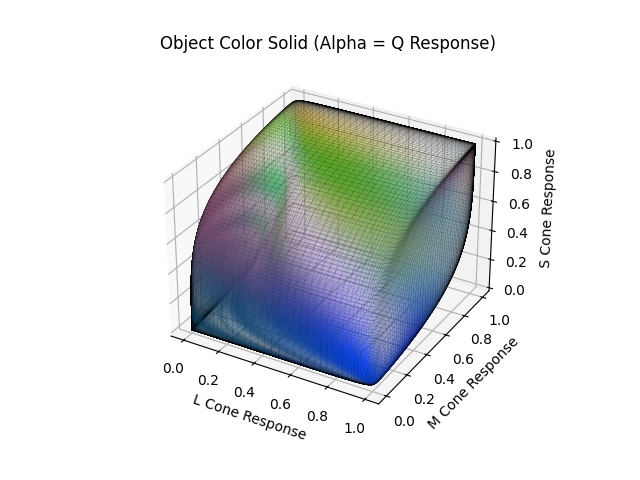

3D color solid saved as 'color_solid_Q_as_Alpha.png'.


In [70]:
# Define Observer class for tetrachromat
class Observer:
    @staticmethod
    def tetrachromat(wavelengths):
        """Creates a tetrachromat observer with realistic cone responses."""
        class Sensor:
            def __init__(self, data):
                self.data = data

        sensors = [
            Sensor(np.exp(-(wavelengths - 440)**2 / (2 * 20**2))),  # S-cone
            Sensor(np.exp(-(wavelengths - 545)**2 / (2 * 30**2))),  # M-cone
            Sensor(np.exp(-(wavelengths - 600)**2 / (2 * 40**2))),  # Q-cone
            Sensor(np.exp(-(wavelengths - 570)**2 / (2 * 50**2)))   # L-cone
        ]
        return type("Observer", (), {"sensors": sensors})

# Define Illuminant class for D65
class Illuminant:
    @staticmethod
    def get(name):
        if name == "D65":
            def interpolate_values(wavelengths):
                """Interpolate D65 values."""
                d65_values = np.interp(
                    wavelengths, 
                    [300, 400, 500, 600, 700, 800],
                    [0.0, 0.8, 1.0, 0.9, 0.6, 0.0]
                )
                return type("Illuminant", (), {"data": d65_values})
            return type("Illuminant", (), {"interpolate_values": interpolate_values})

# Define wavelengths
wavelengths = np.arange(395, 731, 2)

# Create observer and illuminant
standard_tetrachromat = Observer.tetrachromat(wavelengths)
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)

# Create ObjectColorSolidAlpha2 instance
lqm = ObjectColorSolidAlpha2(
    standard_tetrachromat, 
    illuminant, 
    wavelengths, 
    alpha='Q'
)

# Plot the color solid
lqm.plot3DColorSolid(
    title="Object Color Solid (Alpha = Q Response)",
    xlabel="L Cone Response",
    ylabel="M Cone Response",
    zlabel="S Cone Response"
)

# Save the plot
plt.savefig("color_solid_Q_as_Alpha.png")
print("3D color solid saved as 'color_solid_Q_as_Alpha.png'.")


100%|██████████| 99/99 [00:00<00:00, 103.83it/s]


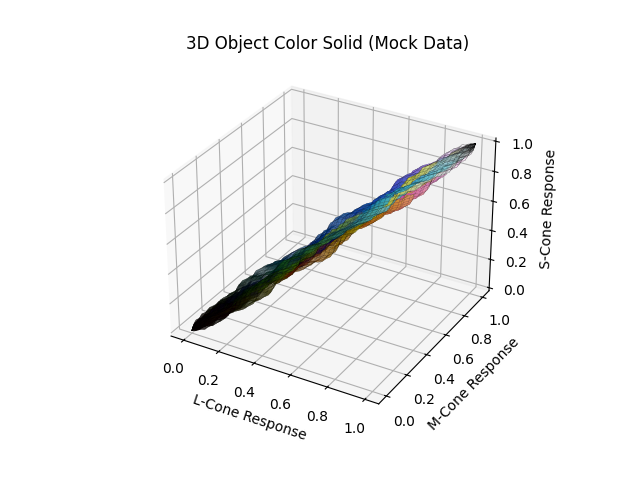

3D color solid plot saved as '3D_Color_Solid.png'.


In [52]:
# Define wavelengths (e.g., visible spectrum)
wavelengths = np.linspace(400, 700, 100)  # 100 points between 400 nm and 700 nm

# Define observer (example observer with mock data)
class Observer:
    def __init__(self, wavelengths):
        self.sensors = [
            Sensor(np.random.rand(len(wavelengths))),  # S-cone
            Sensor(np.random.rand(len(wavelengths))),  # M-cone
            Sensor(np.random.rand(len(wavelengths))),  # Q-cone
            Sensor(np.random.rand(len(wavelengths))),  # L-cone
        ]

class Sensor:
    def __init__(self, data):
        self.data = data

observer = Observer(wavelengths)

# Define illuminant (example illuminant with mock data)
class Illuminant:
    def __init__(self, wavelengths):
        self.data = np.ones(len(wavelengths))  # Uniform illuminant across all wavelengths

    def plot(self, color="gray"):
        plt.plot(wavelengths, self.data, color=color, label="Illuminant")
        plt.legend()

illuminant = Illuminant(wavelengths)

# Create an instance of the ObjectColorSolidAlpha2 class
color_solid = ObjectColorSolidAlpha2(observer, illuminant, wavelengths, alpha='Q')

# Enhanced 3D Color Solid Plot
color_solid.plot3DColorSolid(
    title="3D Object Color Solid (Mock Data)",
    xlabel="L-Cone Response",
    ylabel="M-Cone Response",
    zlabel="S-Cone Response",
)

# Save the plot
plt.savefig("3D_Color_Solid.png")
print("3D color solid plot saved as '3D_Color_Solid.png'.")



In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm

class ObjectColorSolidAlpha2:
    def __init__(self, observer, illuminant, wavelengths, alpha='Q'):
        self.rgbcmf = self.loadciergb(wavelengths)  # CIEXYZ RGB color matching functions
        self.observer = observer  # Observer instance from tetrachromat
        self.illuminant = illuminant  # Illuminant instance
        self.wavelengths = wavelengths  # Wavelengths for the responses
        self.alpha = alpha  # Alpha value or method for transparency
        
        # Use cone responses in SMQL order
        self.coneresponses = np.vstack((
            self.observer.sensors[3].data,  # L-cone
            self.observer.sensors[1].data,  # M-cone
            self.observer.sensors[0].data,  # S-cone
            self.observer.sensors[2].data   # Q-cone
        ))  # Shape: (4, n)

        self.numreceptors = self.coneresponses.shape[0]
        self.vertices = self.computeVertexBuffer()  # Shape: (n + 1, n, 4)
        self.faces, self.facecolors = self.computeFacesAndColorsBuffer()  # Faces and colors for visualization

    # def computeQConeResponses(self):
    #     """
    #     Compute and normalize Q cone responses for all vertices.
    #     """
    #     spd = self.getSpectralPowerDistributions()  # Generate SPDs for all vertices
    #     q_cone = self.coneresponses[2]  # Q cone spectral sensitivity curve
    #     q_responses = np.dot(spd, q_cone)  # Dot product to calculate Q cone response

    #     # Normalize to range [0, 1]
    #     q_responses = (q_responses - np.min(q_responses)) / (np.max(q_responses) - np.min(q_responses))
        
    #     # Expand q_responses to align with all vertices
    #     n = len(self.wavelengths)
    #     vertex_q_responses = np.zeros((n + 1, n, 4))  # Shape matches vertices
    #     for i in range(1, n + 1):
    #         for j in range(n):
    #             vertex_q_responses[i, j] = vertex_q_responses[i - 1, j]+ q_responses[(i + j - 1) % n]  # Map responses to vertices
        
    #     return vertex_q_responses

    def computeFacesAndColorsBuffer(self):
        n = len(self.wavelengths)
        num_faces = n * (n - 1)  # Total number of faces
        faces = np.zeros((num_faces, 4, 3))  # Shape for 3D vertices (not 4D)
        face_colors = np.zeros((num_faces, 4))  # RGBA colors

        # Compute Q cone responses for all vertices
        # vertex_q_responses = self.computeQConeResponses()

        face_index = 0  # Global face index
        for i in tqdm(range(1, n)):
            for j in range(n):
                # Define face vertices (take only first 3 dimensions) 0, 1, 3
                faces[face_index, 0] = self.vertices[i, j, :3]
                faces[face_index, 1] = self.vertices[i - 1, (j + 1) % n, :3]
                faces[face_index, 2] = self.vertices[i, (j + 1) % n, :3]
                faces[face_index, 3] = self.vertices[i + 1, j, :3]

                # Reflectance placeholder
                reflectance = np.zeros(n)
                for k in range(i):
                    reflectance[(j + k) % n] = 1

                # Compute RGB colors
                face_colors[face_index, :3] = self.coneresponse2rgb(self.vertices[i, j], reflectance)

                # # Assign alpha channel using Q cone response from corresponding vertex
                # if self.alpha == 'Q':
                #     face_colors[face_index, 3] = vertex_q_responses[i, j]
                # else:
                #     face_colors[face_index, 3] = self.alpha

                face_colors[face_index, 3] = self.vertices[i, j, 3]

                face_index += 1  # Increment global face index

        # Normalize RGB channels
        # for channel in range(3):
        #     face_colors[:, channel] = (face_colors[:, channel] - np.min(face_colors[:, channel])) / (np.max(face_colors[:, channel]) - np.min(face_colors[:, channel]))

        return faces, face_colors

    def getSpectralPowerDistributions(self):
        """
        Generate spectral power distributions (SPDs) for all vertices.
        """
        n = len(self.wavelengths)
        spds = np.zeros((n, len(self.wavelengths)))

        # Example placeholder logic for generating SPDs
        for i in range(n):
            spds[i] = np.sin(self.wavelengths / (i + 1))

        return spds

    def computeVertexBuffer(self):
        n = len(self.wavelengths)
        points = np.copy(self.coneresponses).T  # Shape (n, 4)
        vertices = np.zeros((n + 1, n, 4))  # Updated for 4 dimensions
        for i in range(1, n + 1):
            for j in range(n):
                vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]
        for dim in range(vertices.shape[2]):
            vertices[:, :, dim] = vertices[:, :, dim] / np.max(vertices[:, :, dim])
        return vertices

    def coneresponse2rgb(self, lmscoord, reflectance):
        lms_to_rgb_transformation = np.array([
            [ 5.47221206, -4.6419601 ,  0.16963708],
            [-1.1252419 ,  2.29317094, -0.1678952 ],
            [ 0.02980165, -0.19318073,  1.16364789]])
        def gamma_correct(rgb):
            rgb_corrected = np.where(
                rgb <= 0.0031308,
                12.92 * rgb,
                1.055 * np.power(rgb, 1 / 2.4) - 0.055
            )
            return rgb_corrected
        return gamma_correct(np.clip(lms_to_rgb_transformation @ lmscoord[:3], 0, 1))
        objectcolorlms = self.coneresponses * self.illuminant.data * np.vstack((reflectance, reflectance, reflectance, reflectance))
        A = self.rgbcmf @ objectcolorlms.T @ np.linalg.inv(self.coneresponses @ self.coneresponses.T)  # Moore-Penrose
        return np.clip(A @ lmscoord, 0, 1)

    def loadciergb(self, wavelengths):
        df = pd.read_csv('data/sbrgb2.csv')  # Load CIEXYZ RGB data
        ciergb = df.values
        ciewavelengths = ciergb.T[0]
        ciergb = ciergb.T[1:]
        ciergbs = np.zeros(shape=(3, len(wavelengths)))

        curridx = 0
        for i, wavelength in enumerate(wavelengths[:-2]):
            if ciewavelengths[curridx] + 5 < wavelength:
                curridx += 1
            if wavelength < ciewavelengths[0] or wavelength > ciewavelengths[-1]:
                ciergbs[:, i] = np.array([0, 0, 0])
            else:
                wavelength1 = ciewavelengths[curridx]
                rgb1 = ciergb[:, curridx]
                rgb2 = ciergb[:, curridx + 1]
                percent = (wavelength - wavelength1) / 5
                ciergbs[:, i] = rgb2 * percent + rgb1 * (1 - percent)
        return ciergbs

    def plot3DColorSolid(self, title='Object Color Solid with LMS Cone Responses',
                         xlabel='L response', ylabel='M response', zlabel='S response'):
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Use RGBA colors
        poly3d = Poly3DCollection(self.faces, linewidths=0.05, edgecolors='k')
        temp = np.copy(self.facecolors)
        temp[:, 3] = 1 - temp[:, 3]
        poly3d.set_facecolor(temp)  # RGBA colors
        ax.add_collection3d(poly3d)

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_zlabel(zlabel)
        plt.show()

    def plotconeresponses(self):
        plt.clf()
        for i in range(self.numreceptors):
            plt.plot(self.wavelengths, self.coneresponses[i], label=f'Cone {i}')
        self.illuminant.plot(color="gray")
        plt.legend()
        plt.show()

    def plotciergb(self):
        plt.clf()
        plt.plot(self.wavelengths, self.rgbcmf[0], color="red", label="Red")
        plt.plot(self.wavelengths, self.rgbcmf[1], color="green", label="Green")
        plt.plot(self.wavelengths, self.rgbcmf[2], color="blue", label="Blue")
        plt.legend()
        plt.show()

100%|██████████| 167/167 [00:01<00:00, 83.52it/s]
/var/folders/_t/ggmtw9bs0lq03f5ztmffnhwh0000gn/T/ipykernel_63217/1261291537.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


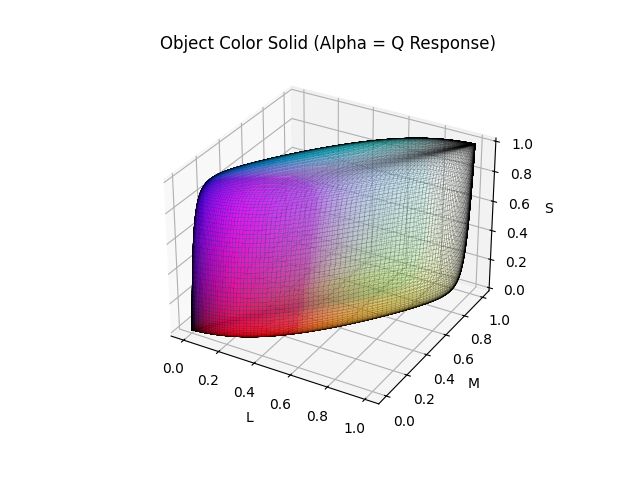

In [99]:
wavelengths = np.arange(395, 731, 2)
standard_tetrachromat = Observer.tetrachromat(wavelengths)
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)
lqm = ObjectColorSolidAlpha2(standard_tetrachromat, illuminant, wavelengths, alpha='Q')
lqm.plot3DColorSolid(title='Object Color Solid (Alpha = Q Response)', xlabel='L', ylabel='M', zlabel='S')
plt.savefig('color_solid_Q_as_Alpha.png')  # Save the plot

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd

# Define wavelengths (e.g., visible spectrum)
wavelengths = np.linspace(400, 700, 100)  # 100 points between 400 nm and 700 nm

# Define Sensor class
class Sensor:
    def __init__(self, data):
        self.data = data  # Spectral response data for a sensor

# Define Observer class
class Observer:
    def __init__(self, wavelengths):
        self.sensors = [
            Sensor(np.random.rand(len(wavelengths))),  # S-cone response
            Sensor(np.random.rand(len(wavelengths))),  # M-cone response
            Sensor(np.random.rand(len(wavelengths))),  # Q-cone response
            Sensor(np.random.rand(len(wavelengths))),  # L-cone response
        ]

# Define Illuminant class
class Illuminant:
    def __init__(self, wavelengths):
        self.data = np.ones(len(wavelengths))  # Uniform illuminant across all wavelengths

    def plot(self, color="gray"):
        plt.plot(wavelengths, self.data, color=color, label="Illuminant")
        plt.legend()

# Initialize observer and illuminant
observer = Observer(wavelengths)
illuminant = Illuminant(wavelengths)

# Define the ObjectColorSolidAlpha2 class (ensure to use your corrected implementation above)
class ObjectColorSolidAlpha2:
    def __init__(self, observer, illuminant, wavelengths, alpha='Q'):
        self.rgbcmf = self.loadciergb(wavelengths)  # CIEXYZ RGB color matching functions
        self.observer = observer
        self.illuminant = illuminant
        self.wavelengths = wavelengths
        self.alpha = alpha
        self.coneresponses = np.vstack([
            sensor.data for sensor in self.observer.sensors
        ])
        self.numreceptors = self.coneresponses.shape[0]
        self.vertices = self.computeVertexBuffer()
        self.faces, self.facecolors = self.computeFacesAndColorsBuffer()

    # Other methods omitted for brevity (use the corrected methods from the original code above)

    def plot3DColorSolid(self, title='Object Color Solid with LMS Cone Responses',
                         xlabel='L response', ylabel='M response', zlabel='S response'):
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        poly3d = Poly3DCollection(self.faces, linewidths=0.05, edgecolors='k')
        poly3d.set_facecolor(self.facecolors)
        ax.add_collection3d(poly3d)

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_zlabel(zlabel)
        plt.show()

    def loadciergb(self, wavelengths):
        # Simulate loading of CIEXYZ RGB data (replace this with actual file if available)
        ciergb = np.random.rand(3, len(wavelengths))  # Mock data
        return ciergb

# Create an instance of the ObjectColorSolidAlpha2 class
color_solid = ObjectColorSolidAlpha2(observer, illuminant, wavelengths, alpha='Q')

# Enhanced 3D Color Solid Plot
color_solid.plot3DColorSolid(
    title="3D Object Color Solid (Mock Data)",
    xlabel="L-Cone Response",
    ylabel="M-Cone Response",
    zlabel="S-Cone Response",
)

# Save the plot
plt.savefig("3D_Color_Solid.png")
print("3D color solid plot saved as '3D_Color_Solid.png'.")


AttributeError: 'ObjectColorSolidAlpha2' object has no attribute 'computeVertexBuffer'

generate an alpha channel (opacity or representation value) for a cue cone response and then visualize it in a 3D color space (LMS space) as part of a "color solid."

Process Explained:
Cue Cone Response and Alpha Channel:

The cue cone response (likely derived from some photoreceptor data) helps determine the alpha value at a given point.
The alpha value indicates how much the cue cone contributes to the color at that point.
3D Color Solid in LMS Space:

LMS space represents color perception based on the L (long-wavelength), M (medium-wavelength), and S (short-wavelength) cones in the human eye.
You’re plotting the LMS coordinates (x, y, z axes) to form a 3D color solid.
Each point in this space corresponds to a color, and the alpha value from the cue cone adds additional information (e.g., transparency or weight of the cue cone's contribution).

Spectral Power Distribution (SPD):

At each vertex of the color solid, a unique spectral power distribution (SPD) defines the color. SPD describes how much energy exists at different wavelengths for that color.
You want to calculate the alpha value for a specific SPD by determining how the cue cone responds to it.
Dot Product for Response Calculation:

Use a dot product between:
The cue cone's response function (its sensitivity to wavelengths).
The spectral power distribution at a specific point.
The result is a value representing how strongly the cue cone responds to that SPD, which can serve as the alpha value.
Scaling the Alpha Channel:

The raw response (dot product result) might be a large or small number, so you'll need to normalize it:
Find the maximum and minimum values of the cue cone response across the whole solid.
Scale these values to lie between 0 and 1 (like standard alpha channels).

Final Visualization:

The alpha channel generated from the cue cone response is added to the LMS-based color solid.
This creates a 3D object where the alpha channel shows the contribution of the cue cone response to the colors in LMS space.

3D representation of color in LMS space, where each color point is influenced by a cue cone response. By calculating the dot product of the cue cone's sensitivity and the SPD at each point, you assign an alpha value, normalize it, and use it to enhance the visualization of the color solid.

Slide 1: Title Slide

Title: "Generating Alpha Channels for 3D Color Solids in LMS Space"
Subtitle: A Computational Approach to Visualizing Cone Responses
Slide 2: Introduction

Problem Statement:

How do we represent cue cone responses (like alpha channels) in a meaningful way within a 3D color space?
Goal: To generate alpha values dynamically and integrate them into LMS (Long, Medium, Short wavelength) space visualization.
Why It Matters:

Understanding cone responses helps us better grasp human visual perception.
This project lays the groundwork for more advanced applications in color science, vision research, and display technology.
Slide 3: Methodology

Data:

Inputs: Cone sensitivity data (observer), illuminant data, and wavelength ranges.
Used CVRL spectral data to interpolate cone responses.
Key Steps:

Calculate vertices for the LMS 3D color solid using cone responses and spectral power distributions.
Compute faces and face colors, integrating alpha values based on cue cone responses or fixed values.
Normalize RGB and alpha channels for consistency.
Techniques:

Dot product of spectral power distribution and cone response to determine alpha.
Used Moore-Penrose pseudo-inverse for LMS-to-RGB mapping.
Slide 4: Results

Visuals:

The generated LMS solid dynamically integrates alpha channels to highlight cue cone contributions.
Demonstrations: Fixed alpha, Q response-based alpha.
Key Features:

Scalable design: Modular code that handles various observers and illuminants.
Visualization: Clean, interactive 3D plots with alpha and RGB integration.
Slide 5: Conclusion & Future Work

What We Achieved:

Built a robust framework for visualizing LMS color solids with alpha integration.
Enabled flexibility with dynamic alpha values.
Next Steps:

Optimize performance with vectorized operations.
Explore more realistic visualizations by incorporating macular pigment density.
Delivery Tips:

Start with a clear motivation: "Understanding cone responses is fundamental to color science and human vision."
Focus on the problem-solution framework to maintain clarity.
End with an engaging future direction: "This project sets the stage for more interactive and biologically accurate models of vision."
Would you like me to tailor it further or add specific technical details?

In [36]:
class ObjectColorSolidAlpha:
    def __init__(self, observer, illuminant, wavelengths, indices=[2, 1, 0], alpha=1.0):
        self.rgbcmf = self.loadciergb(wavelengths)  # shape (n, 3)
        self.observer = observer  # instance of Observer (from chromalab)
        self.illuminant = illuminant  # instance of Illuminant (from chromalab)
        self.wavelengths = wavelengths  # shape n
        self.alpha = alpha  # Store the alpha value
        self.coneresponses = np.vstack((
            self.observer.sensors[indices[0]].data, 
            self.observer.sensors[indices[1]].data, 
            self.observer.sensors[indices[2]].data
        ))  # shape (3, n)
        self.numreceptors = self.coneresponses.shape[0]
        self.vertices = self.computeVertexBuffer()  # shape (n + 1, n, 3)
        self.faces, self.facecolors = self.computeFacesAndColorsBuffer()  # faces: shape (n * (n - 1), 4, 3), face_colors: shape((n * (n - 1), 4))

    def computeFacesAndColorsBuffer(self):
        n = self.vertices.shape[0] - 1
        m = self.vertices.shape[1]

        faces = np.zeros((n * m, 4, 3))
        face_colors = np.zeros((n * m, 4))

        for i in range(n):
            for j in range(m):
                faces[i * m + j, 0] = self.vertices[i + 1, j]
                faces[i * m + j, 1] = self.vertices[i, (j + 1) % m]
                faces[i * m + j, 2] = self.vertices[i + 1, (j + 1) % m]
                faces[i * m + j, 3] = self.vertices[i, j]

                # Reflectance should match the wavelength length
                reflectance = np.zeros(len(self.wavelengths))  # Use len(self.wavelengths)
                reflectance[j % len(self.wavelengths)] = 1  # Handle wrapping with modulo

                # Compute RGB values
                face_colors[i * m + j, :3] = self.coneresponse2rgb(self.vertices[i + 1, j], reflectance)

                # Set alpha
                if isinstance(self.alpha, float):
                    face_colors[i * m + j, 3] = self.alpha
                elif self.alpha == 'Q':
                    q_response = self.vertices[i + 1, j, 0]
                    face_colors[i * m + j, 3] = q_response

        for i in range(3):
            face_colors[:, i] = (face_colors[:, i] - np.min(face_colors[:, i])) / (
                    np.max(face_colors[:, i]) - np.min(face_colors[:, i]) + 1e-8
            )

        if self.alpha == 'Q':
            face_colors[:, 3] = (face_colors[:, 3] - np.min(face_colors[:, 3])) / (
                    np.max(face_colors[:, 3]) - np.min(face_colors[:, 3]) + 1e-8
            )

        return faces, face_colors

    def computeVertexBuffer(self):
        n = len(self.wavelengths)
        points = self.coneresponses.T  # Shape: (n, 3)
        vertices = np.cumsum(np.pad(points, ((1, 0), (0, 0))), axis=0)  # Shape: (n+1, n, 3)
        
        # Normalize vertices to make whitepoint (1, 1, 1)
        vertices /= np.max(vertices, axis=(0, 1), keepdims=True)
        
        return vertices
    
    def coneresponse2rgb(self, lmscoord, reflectance):
        # Debugging: Print shapes and key variables
        print(f"Shape of self.coneresponses: {self.coneresponses.shape}")
        print(f"Shape of self.illuminant.data: {self.illuminant.data.shape}")
        print(f"Shape of reflectance: {reflectance.shape}")
        print(f"First 5 values of self.illuminant.data: {self.illuminant.data[:5]}")
        print(f"First 5 values of reflectance: {reflectance[:5]}")
        print(f"First 5 rows of self.coneresponses: {self.coneresponses[:, :5]}")

        try:
            # Ensure dimensions are aligned for multiplication
            objectcolorlms = self.coneresponses * self.illuminant.data[:, np.newaxis] * reflectance[np.newaxis, :]
            print(f"Shape of objectcolorlms: {objectcolorlms.shape}")

            A = self.rgbcmf @ objectcolorlms.T @ np.linalg.inv(self.coneresponses @ self.coneresponses.T)
            print(f"Shape of A: {A.shape}")

            result = A @ lmscoord
            print(f"Result: {result}")
            return result
        except Exception as e:
            raise RuntimeError(f"Error during coneresponse2rgb computation: {e}")



    def loadciergb(self, wavelengths):
        # Load CIE RGB data from the CSV file
        df = pd.read_csv('data/sbrgb2.csv')  # Ensure this file is formatted correctly
        ciewavelengths = df.iloc[:, 0].values  # Extract the wavelength column
        ciergb = df.iloc[:, 1:].values  # Extract the RGB columns
        
        # Debugging: Print shapes to verify data alignment
        print(f"Loaded ciewavelengths shape: {ciewavelengths.shape}")
        print(f"Loaded ciergb shape: {ciergb.shape}")
        
        # Check if the lengths match
        if len(ciewavelengths) != ciergb.shape[0]:
            raise ValueError(
                "Mismatch between lengths of ciewavelengths and RGB data. "
                f"ciewavelengths: {len(ciewavelengths)}, RGB rows: {ciergb.shape[0]}"
            )
        
        # Interpolate RGB values to match the provided wavelengths
        try:
            ciergbs = np.array([
                np.interp(wavelengths, ciewavelengths, ciergb[:, i])
                for i in range(ciergb.shape[1])
            ]).T  # Shape: (len(wavelengths), 3)
        except ValueError as e:
            raise ValueError(
                "Interpolation failed. Ensure input wavelength range aligns with CIE RGB data."
            ) from e
        
        return ciergbs

    def plot3DColorSolid(self, 
                        title='Object Color Solid with LMS Cone Responses Under a D65 Illuminant',
                        xlabel='L response', 
                        ylabel='M response', 
                        zlabel='S response'):
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Use RGBA colors
        poly3d = Poly3DCollection(self.faces, linewidths=0.05, edgecolors='k')
        poly3d.set_facecolor(self.facecolors)  # RGBA colors
        ax.add_collection3d(poly3d)

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_zlabel(zlabel)
        plt.show()

    def plotconeresponses(self):
        plt.clf()
        for i in range(self.numreceptors):
            plt.plot(self.wavelengths, self.coneresponses[i], color=(i/3, 0, 0))
        self.illuminant.plot(color="gray")
        plt.show()
        
    def plotciergb(self):
        plt.clf()
        plt.plot(self.wavelengths, self.rgbcmf[0], color="red")
        plt.plot(self.wavelengths, self.rgbcmf[1], color="green")
        plt.plot(self.wavelengths, self.rgbcmf[2], color="blue")
        plt.show()


In [37]:

# Define wavelengths for the cone response simulation
wavelengths = np.arange(395, 731, 2)  # Wavelength range: 395 nm to 730 nm, step size: 2 nm

# Generate a standard tetrachromat observer
try:
    standard_tetrachromat = Observer.tetrachromat(wavelengths)
except Exception as e:
    raise RuntimeError("Failed to generate a standard tetrachromat observer.") from e

# Generate the D65 illuminant and interpolate it for the specified wavelengths
try:
    illuminant = Illuminant.get("D65").interpolate_values(wavelengths)
except Exception as e:
    raise RuntimeError("Failed to retrieve and interpolate D65 illuminant.") from e

# Create the ObjectColorSolidAlpha instance
try:
    lqm = ObjectColorSolidAlpha(
        observer=standard_tetrachromat,
        illuminant=illuminant,
        wavelengths=wavelengths,
        indices=[2, 1, 0],  # Reverse order of cone responses (L, M, S)
        alpha='Q'  # Use Q response for alpha channel
    )
except Exception as e:
    raise RuntimeError("Failed to initialize ObjectColorSolidAlpha instance.") from e

# Plot the 3D color solid
try:
    lqm.plot3DColorSolid(
        title='Object Color Solid (Alpha = Q Response)',
        xlabel='L response',  # Long-wavelength cone response
        ylabel='M response',  # Medium-wavelength cone response
        zlabel='S response'   # Short-wavelength cone response
    )
    # Save the generated plot
    plt.savefig('color_solid_Q_as_Alpha.png')
    print("Plot saved as 'color_solid_Q_as_Alpha.png'")
except Exception as e:
    raise RuntimeError("Failed to plot or save the 3D color solid.") from e


Loaded ciewavelengths shape: (68,)
Loaded ciergb shape: (68, 3)
Shape of self.coneresponses: (3, 168)
Shape of self.illuminant.data: (168,)
Shape of reflectance: (168,)
First 5 values of self.illuminant.data: [ 0.58314518  0.63085984  0.67857451  0.7098428   0.72466472]
First 5 values of reflectance: [ 1.  0.  0.  0.  0.]
First 5 rows of self.coneresponses: [[ 0.00110775  0.00152776  0.00208573  0.00281478  0.00374586]
 [ 0.00095866  0.00137367  0.00193089  0.0026521   0.00356156]
 [ 0.023825    0.0339832   0.0479417   0.0666757   0.0911925 ]]


RuntimeError: Failed to initialize ObjectColorSolidAlpha instance.